# Credit Card Fraud Prediction Models

In this kernel we will evaluate different classification models and use different methods for handling imbalanced data.

 1. using class weights in our classification model
 2. using random undersampling during training

### Imports and helper functions

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression


In [2]:
def draw_pr_curve(y_true, scores):
    """
    draws precision-recall curves
    """
    prec, recall, thresholds = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    plt.figure()
    lw = 2
    plt.plot(prec, recall, color='darkorange',
             lw=lw, label='Average Precision (ap = %0.2f)' % ap)
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()

def draw_confusion_matrix(y_true, pred, normalize=True, print_report=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    draws confusion matrices and print a classification report
    """
    cm = confusion_matrix(y_true, pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, None]
    
    sns.heatmap(cm, cmap='coolwarm_r', linewidths=0.5, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    if print_report:
        print('---Classification Report---')
        print(classification_report(y_true, pred)) 

### Reading in the data

In [8]:
df = pd.read_csv("Data/creditcard.csv")
#df.head()

## Logistic Regression

### Data preprocessing

For the "Time" feature we replace "elapsed time" with the "TimeTag" feature (EDA) and standardize our features.

In [16]:
X = df.drop(columns=["Class"])
y = df.Class.values


def replace_time(df, tag=False):
    clock_time = (df["Time"]/3600.0)%24
    
    # use TimeTag (from EDA) instead of normal time
    if tag:
        TimeTag = np.array((clock_time < 6) , dtype=np.int8)
        return df.assign(Time = TimeTag)
    else:
        return df.assign(Time = clock_time)


X = replace_time(X, tag=True)
X = X.values

### Class weights

One straight forward way to handle class imbalances is the use of class weight.

To determine the right class weights we will use cross validation.

Since the data is heavily imbalanced we don't want to use accuracy (classifying every sample with 0 gives an accuracy of 99.83%). Also ROC-curves have their problems with highly imbalanced data and give an overly-optimistic score, because the TN-rate is very high in this cases. 

Therefore we use average precision (ap) or the area under the Precision-Recall curve as out main metric.

In [79]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

weights = [1, 10, 20, 50, 100]

results_table = pd.DataFrame(index=range(len(weights)), columns=["class_weight", "mAP", "mF1-score", "mRecall", "mPrecision", "AP_Fold_1","AP_Fold_2","AP_Fold_3","AP_Fold_4","AP_Fold_5"])
results_table["class_weight"] = weights

for i, weight in enumerate(tqdm(weights)):
    
    APs = []
    F_scores = []
    Recall_scores = []
    Precision_scores = []
        
    for fold_nr, (train_index, test_index) in enumerate(tqdm(skf.split(X, y))):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(class_weight={0:1,1:weight}, max_iter=250)
        
        # we use RobustScaler which uses median and interquartile range instead of mean and std  
        scaler = RobustScaler()
        scaler.fit(X_train)
        
        model.fit(scaler.transform(X_train), y_train)
        
        scores = model.predict_proba(scaler.transform(X_test))[:,1]
        ap = average_precision_score(y_test, scores)
        f_score = f1_score(y_test, scores > 0.5)
        recall = recall_score(y_test, scores > 0.5)
        precision = precision_score(y_test, scores > 0.5)
        APs.append(ap)
        F_scores.append(f_score)
        Recall_scores.append(recall)
        Precision_scores.append(precision)
        #print(ap)
        results_table.loc[i, ("AP_Fold_"+str(1+fold_nr))] = ap
    
    mAP = np.mean(APs)
    mF1 = np.mean(F_scores)
    mRecall = np.mean(Recall_scores)
    mPrecision = np.mean(Precision_scores)
    
    results_table.loc[i,"mAP"] = mAP
    results_table.loc[i,"mF1-score"] = mF1
    results_table.loc[i,"mRecall"] = mRecall
    results_table.loc[i,"mPrecision"] = mPrecision

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


KeyError: "None of [Int64Index([     0,      3,      4,      5,      6,      7,      9,     10,\n                12,     13,\n            ...\n            284792, 284795, 284797, 284798, 284799, 284800, 284801, 284802,\n            284805, 284806],\n           dtype='int64', length=227845)] are in the [columns]"

In [6]:
results_table

,class_weight,mAP,mF1-score,mRecall,mPrecision,,AP_Fold_1,AP_Fold_2,AP_Fold_3,AP_Fold_4,AP_Fold_5
0,1,0.758725,0.719522,0.617934,0.864544,NaN,0.768639,0.80203,0.731441,0.711745,0.77977
1,10,0.760963,0.787416,0.814945,0.762263,NaN,0.782821,0.812177,0.732997,0.701199,0.775619
2,20,0.756894,0.741184,0.82717,0.67239,NaN,0.779568,0.808477,0.727578,0.696755,0.772091
3,50,0.75216,0.625587,0.851515,0.495276,NaN,0.77306,0.803118,0.72492,0.691362,0.76834
4,100,0.749437,0.424009,0.86576,0.28134,NaN,0.76811,0.796274,0.728854,0.685315,0.768631


The class weight 10 performs best in cross_validation (regarding average precision).

Let's take a closer look at the classifier at Fold 5 (where classification performance resembles the average the most)

In [7]:
train_idx, test_idx = list(skf.split(X,y))[4]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

model = LogisticRegression(class_weight={0:1,1:10}, max_iter=250)

scaler = RobustScaler()
scaler.fit(X_train)

model.fit(scaler.transform(X_train), y_train)

scores = model.predict_proba(scaler.transform(X_test))[:,1]

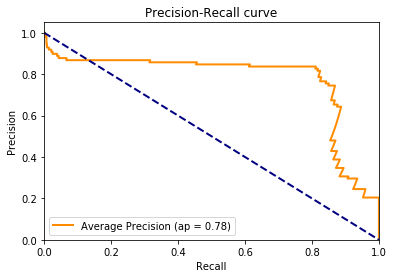

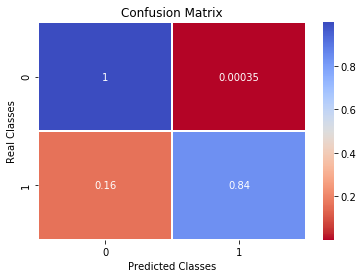

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56961
   macro avg       0.90      0.92      0.91     56961
weighted avg       1.00      1.00      1.00     56961



In [8]:
draw_pr_curve(y_test, scores)
draw_confusion_matrix(y_test, scores > 0.5)

We can see that just tuning the class weights for logistic regression can give a good classifier.

Note that in a real world fraud detector one would - depending on the cost of FPs and FNs - tune a classifier a bit more. <br>
For example with the cost for False Negatives is very low, one would prefer a model with higher recall.

### Undersampling

Another way to handle class imbalances is to randomly undersample the non-fraudulent samples in training.

In [9]:
def undersample(X, y, sample_factor=1, shuffled=True, random_state=None):
    """
    Undersamples the non-fraudulent samples
    
    sample_factor gives the amount of non-fraud samples for every fraud sample
    """
    X_fraud = X[y==1]
    X_non_fraud = X[y==0]
    
    fraud_samples = len(X_fraud)
    non_fraud_total = len(X_non_fraud)
        
    np.random.RandomState(seed=random_state)
    non_fraud_indices = np.random.choice(non_fraud_total, int(fraud_samples*sample_factor), replace=False)
    
    X_no_undersampled = X_non_fraud[non_fraud_indices]
    
    X_undersampled = np.concatenate((X_fraud, X_no_undersampled))
    y_undersampled = np.concatenate((np.ones(fraud_samples), np.zeros(len(X_no_undersampled))))
    
    if shuffled:
        X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=random_state)
    
    return X_undersampled , y_undersampled  


In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

sample_factors = [1, 1.5, 2, 4, 6, 9, 19, 39, 59, 79]

results_table = pd.DataFrame(index=range(len(sample_factors)), columns=["sample_factors", "mAP", "mF1-score", "mRecall", "mPrecision", "AP_Fold_1","AP_Fold_2","AP_Fold_3","AP_Fold_4","AP_Fold_5"])
results_table["sample_factors"] = sample_factors

for i, factor in enumerate(tqdm(sample_factors)):
    
    APs = []
    F_scores = []
    Recall_scores = []
    Precision_scores = []
        
    for fold_nr, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=250)
        
        # we use RobustScaler which uses median and interquartile range instead of mean and std  
        scaler = RobustScaler()
        scaler.fit(X_train)
        X_undersampled, y_undersampled = undersample(scaler.transform(X_train), y_train, sample_factor=factor, random_state=12)
        
        model.fit(X_undersampled, y_undersampled)
        
        scores = model.predict_proba(scaler.transform(X_test))[:,1]
        ap = average_precision_score(y_test, scores)
        f_score = f1_score(y_test, scores > 0.5)
        recall = recall_score(y_test, scores > 0.5)
        precision = precision_score(y_test, scores > 0.5)
        APs.append(ap)
        F_scores.append(f_score)
        Recall_scores.append(recall)
        Precision_scores.append(precision)
        #print(ap)
        results_table.loc[i, ("AP_Fold_"+str(1+fold_nr))] = ap
    
    mAP = np.mean(APs)
    mF1 = np.mean(F_scores)
    mRecall = np.mean(Recall_scores)
    mPrecision = np.mean(Precision_scores)
    
    results_table.loc[i,"mAP"] = mAP
    results_table.loc[i,"mF1-score"] = mF1
    results_table.loc[i,"mRecall"] = mRecall
    results_table.loc[i,"mPrecision"] = mPrecision

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]


In [11]:
results_table

,sample_factors,mAP,mF1-score,mRecall,mPrecision,AP_Fold_1,AP_Fold_2,AP_Fold_3,AP_Fold_4,AP_Fold_5
0,1.0,0.578576,0.0927839,0.906473,0.0491229,0.614807,0.738017,0.544067,0.559162,0.436826
1,1.5,0.630402,0.12072,0.900371,0.0647511,0.659236,0.614944,0.654665,0.592326,0.630839
2,2.0,0.679179,0.141569,0.900371,0.0769145,0.617569,0.71436,0.689964,0.623543,0.750457
3,4.0,0.710854,0.255259,0.880066,0.150331,0.769414,0.721917,0.722442,0.608388,0.73211
4,6.0,0.718339,0.366268,0.867821,0.232978,0.765665,0.73944,0.71805,0.641763,0.726775
5,9.0,0.716764,0.46934,0.857617,0.324107,0.766298,0.758189,0.672805,0.639796,0.746731
6,19.0,0.726322,0.653383,0.839353,0.537069,0.766752,0.768197,0.686763,0.658817,0.751082
7,39.0,0.741127,0.728055,0.806782,0.663614,0.74581,0.8031,0.698506,0.696179,0.762039
8,59.0,0.758491,0.782599,0.810884,0.756762,0.78093,0.809424,0.733112,0.695433,0.773555
9,79.0,0.755639,0.774687,0.798701,0.752713,0.76724,0.806616,0.724256,0.701748,0.778335


- We can see that undersampling is a valid strategy for dealing with highly imbalanced data.
- As the amount of non-fraudulent samples increases recall drops and average precision increases
- The sample factor 79 performs best (regarding AP), however worse than the classifier trained using class weights in both AP and recall
- A big advantage of undersampling compared to using class weights is that training is much faster, due to the much smaller training set

Let's again take a closer look at the classifier at fold 5

In [12]:
train_idx, test_idx = list(skf.split(X,y))[4]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

model = LogisticRegression(max_iter=250)

# we use RobustScaler which uses median and interquartile range instead of mean and std  
scaler = RobustScaler()
scaler.fit(X_train)
X_undersampled, y_undersampled = undersample(scaler.transform(X_train), y_train, sample_factor=79, random_state=12)

model.fit(X_undersampled, y_undersampled)

scores = model.predict_proba(scaler.transform(X_test))[:,1]

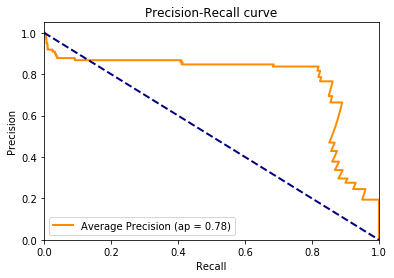

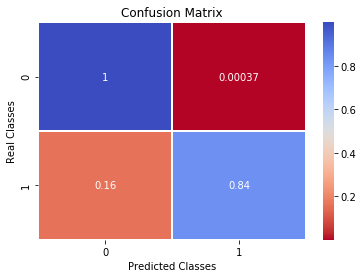

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56961
   macro avg       0.90      0.92      0.91     56961
weighted avg       1.00      1.00      1.00     56961



In [13]:
draw_pr_curve(y_test, scores)
draw_confusion_matrix(y_test, scores > 0.5)

### Outlier Removal

During EDA we noticed there is quite an amount of outliers in our features.

Removing them **might** help with training a better model. However just generally dropping outliers may not be good idea, since the data set is heavily imbalanced and being an outlier might be characteristic for the sought after fraud cases. Therefore we will only remove some outliers from the training sets for non-fraudulent samples. 


In [23]:
corr_features = ["V1", "V2", "V3",  "V4",  "V5",  "V7",  "V9", "V10",  "V11", "V12", "V14", "V16", "V17", "V18"]
def outlier_removal(X, y=None, cols=corr_features, label_col="Class", iqr_factor=1.5, verbose=False):
    
    if y is not None:
        non_frauds = X[cols].loc[y==0]
    else:
        non_frauds = X[cols].loc[X[label_col]==0]
        
    q25 = non_frauds.quantile(0.25)
    q75 = non_frauds.quantile(0.75)
    
    iqr = q75 - q25
    cut_off = iqr*iqr_factor
    
    lower_cut_off = q25 - cut_off
    upper_cut_off = q75 + cut_off
    
    outlier_values = (non_frauds < lower_cut_off)|(non_frauds > upper_cut_off) # this is a data frame filled with True/False
    outlier_rows = outlier_values.any(axis=1) # series filled with bools indicating outliers
    
    outlier_ids = non_frauds[outlier_rows].index
    
    if verbose:
        print(f"Removed {len(outlier_ids)} outliers from {len(X)} original samples.")
    
    if y is not None:
        return X.drop(index=outlier_ids), y.drop(index=outlier_ids)
    
    else:
        return X.drop(index=outlier_ids)


Let's take a look at the box plots of the correlated features from EDA again, but this time with the outliers removed.

Removed 11086 outliers from 284807 original samples.


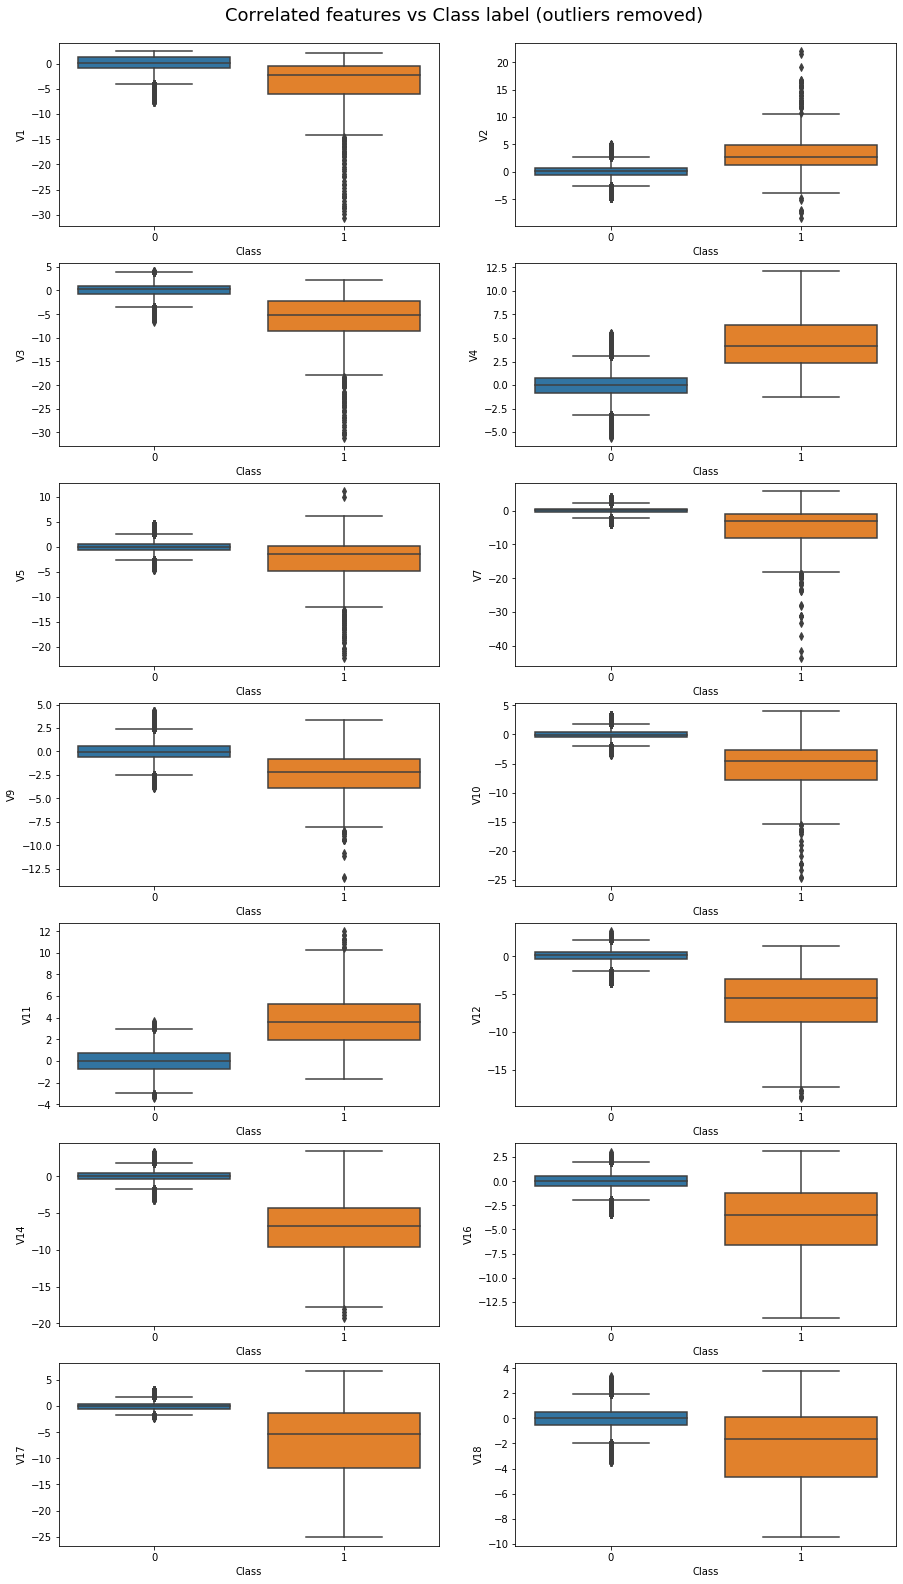

In [63]:
cleaned_df = outlier_removal(df, cols=corr_features, verbose=True, iqr_factor=3)
f, axs = plt.subplots(nrows=7, ncols=2, figsize=(15,25))
for ax,feat in zip(axs.reshape(-1),corr_features):
    sns.boxplot(x=cleaned_df.Class, y=df[feat], ax=ax)
    #ax.set_title(feat)
f.suptitle("Correlated features vs Class label (outliers removed)", fontsize=18)
plt.subplots_adjust(top=0.96)
plt.show()

#### Train a model on data with removed outliers

In [64]:
X = df.drop(columns=["Class"])
# use TimeTag (from EDA) instead of normal time
TimeTag = (X["Time"]/3600)%24
X["Time"] = np.array((TimeTag < 6) , dtype=np.int8) 
y = df.Class.copy()


In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

weights = [1, 10, 20, 50, 100]

results_table = pd.DataFrame(index=range(len(weights)), columns=["class_weight", "mAP", "mF1-score", "mRecall", "mPrecision", "", "AP_Fold_1","AP_Fold_2","AP_Fold_3","AP_Fold_4","AP_Fold_5"])
results_table["class_weight"] = weights

for i, weight in enumerate(tqdm(weights)):
    
    APs = []
    F_scores = []
    Recall_scores = []
    Precision_scores = []
        
    for fold_nr, (train_index, test_index) in enumerate(tqdm(skf.split(X, y))):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train, y_train = outlier_removal(X_train, y=y_train, iqr_factor=3)
        
        model = LogisticRegression(class_weight={0:1,1:weight}, max_iter=350)
        
        # we use RobustScaler which uses median and interquartile range instead of mean and std  
        scaler = RobustScaler()
        scaler.fit(X_train)
        
        model.fit(scaler.transform(X_train), y_train)
        
        scores = model.predict_proba(scaler.transform(X_test))[:,1]
        ap = average_precision_score(y_test, scores)
        f_score = f1_score(y_test, scores > 0.5)
        recall = recall_score(y_test, scores > 0.5)
        precision = precision_score(y_test, scores > 0.5)
        APs.append(ap)
        F_scores.append(f_score)
        Recall_scores.append(recall)
        Precision_scores.append(precision)
        #print(ap)
        results_table.loc[i, ("AP_Fold_"+str(1+fold_nr))] = ap
    
    mAP = np.mean(APs)
    mF1 = np.mean(F_scores)
    mRecall = np.mean(Recall_scores)
    mPrecision = np.mean(Precision_scores)
    
    results_table.loc[i,"mAP"] = mAP
    results_table.loc[i,"mF1-score"] = mF1
    results_table.loc[i,"mRecall"] = mRecall
    results_table.loc[i,"mPrecision"] = mPrecision

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:03,  3.33s/it]
2it [00:06,  3.41s/it]
3it [00:10,  3.43s/it]
4it [00:14,  3.51s/it]
5it [00:18,  3.65s/it]
 20%|████████████████▊                                                                   | 1/5 [00:18<01:12, 18.25s/it]
0it [00:00, ?it/s]
1it [00:05,  5.18s/it]
2it [00:09,  4.91s/it]
3it [00:14,  4.86s/it]
4it [00:20,  5.19s/it]
5it [00:25,  5.11s/it]
 40%|█████████████████████████████████▌                                                  | 2/5 [00:43<01:01, 20.43s/it]
0it [00:00, ?it/s]
1it [00:06,  6.42s/it]
2it [00:12,  6.40s/it]
3it [00:19,  6.47s/it]
4it [00:26,  6.74s/it]
5it [00:31,  6.34s/it]
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:15<00:47, 23.82s/it]
0it [00:00, ?it/s]
1it [00:07,  7.95s/it]
2it [00:15,  7.73s/it]
3it [00:25,  8.49s/it]
4it [00:30,  7.61s/it]
5it [00

In [66]:
results_table

,class_weight,mAP,mF1-score,mRecall,mPrecision,,AP_Fold_1,AP_Fold_2,AP_Fold_3,AP_Fold_4,AP_Fold_5
0,1,0.70032,0.601027,0.825149,0.473161,NaN,0.710425,0.755833,0.700063,0.615425,0.719856
1,10,0.726154,0.482249,0.855617,0.336113,NaN,0.749483,0.786653,0.71786,0.636882,0.739891
2,20,0.724095,0.400843,0.859678,0.26154,NaN,0.734406,0.777851,0.727489,0.642894,0.737837
3,50,0.709379,0.276021,0.869821,0.164085,NaN,0.713696,0.732462,0.719364,0.639763,0.741612
4,100,0.696451,0.21471,0.886106,0.12218,NaN,0.691967,0.724614,0.69834,0.631149,0.736187


As we can see removing outliers from non-fraud samples during training does not improve performance of the model. 

## Decision Trees

In this section we'll test the performance of Random Forrest classifiers on our data by building a pipeline and performing grid search.  

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [17]:
X = df.drop(columns=["Class"])
y = df["Class"].values
X = replace_time(X, tag=True)

In [18]:
pipe = Pipeline([("Robust Scaler", RobustScaler()),
                 ("clf", RandomForestClassifier(n_estimators=20))
                ])

In [19]:
param_grid = {"clf__class_weight": [{0:1,1:1}, {0:1,1:10}, {0:1,1:25}, {0:1,1:50}], "clf__max_depth": [5, 8]}

In [20]:
scoring = ["average_precision", "f1", "recall", "precision"]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=7, scoring=scoring, refit="average_precision")

In [21]:
gs.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Robust Scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                     

In [22]:
columns = ["param_clf__class_weight", "param_clf__max_depth"]+["mean_test_" + scorer for scorer in scoring]
results = pd.DataFrame(gs.cv_results_)[columns]
weights = [c[1] for c in gs.cv_results_["param_clf__class_weight"].compressed()]
results = results.assign(param_clf__class_weight=weights)

results.columns = [c.replace("param_clf__", "").replace("mean_test_","") for c in results.columns]
results

,class_weight,max_depth,average_precision,f1,recall,precision
0,1,5,0.747153,0.774234,0.702886,0.892896
1,1,8,0.766020,0.797041,0.735560,0.891343
2,10,5,0.747767,0.806703,0.776149,0.853311
3,10,8,0.768162,0.797388,0.737415,0.889058
4,25,5,0.740899,0.811785,0.794434,0.842747
5,25,8,0.771136,0.822158,0.774088,0.890475
6,50,5,0.747370,0.806507,0.792373,0.831733
7,50,8,0.756878,0.808812,0.761884,0.877795


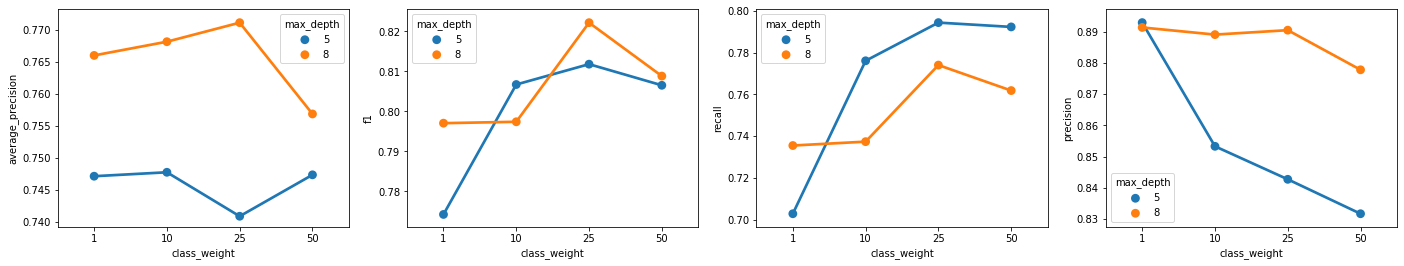

In [23]:
f,ax = plt.subplots(1,4, figsize=(24,4))

sns.pointplot(x="class_weight", y="average_precision", hue="max_depth", data=results, ax=ax[0])
sns.pointplot(x="class_weight", y="f1", hue="max_depth", data=results, ax=ax[1])
sns.pointplot(x="class_weight", y="recall", hue="max_depth", data=results, ax=ax[2])
sns.pointplot(x="class_weight", y="precision", hue="max_depth", data=results, ax=ax[3])
plt.show()

Random Forest classifiers tend to have better precision than logistic regression, however in our case recall is more important.